In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [3]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/', transform=test_data_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [4]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [5]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
#         self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / QK.size(1)
        QK = torch.matmul(QK, QK.permute(0,2,1)).sum(1)
        QK = QK.sigmoid()
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x3_emb
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        x_out = x_out + x #residual
        
        return x_out

In [6]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64, 64, emb_dim=32).to(self.device)
        self.wf1 = Attention(128, 128, emb_dim=64).to(self.device)
        self.wf2 = Attention(256, 256, emb_dim=128).to(self.device)
        self.wf3 = Attention(512, 512, emb_dim=256).to(self.device)
        self.wf4 = Attention(1024, 1024, emb_dim=512).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_1'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.864  | Avg.acc: 0.250
- Avg. val_loss: 1.820  | Avg. val_acc: 0.284
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.644  | Avg.acc: 0.345
- Avg. val_loss: 1.778  | Avg. val_acc: 0.308
* Update optimal model
Epoch:  3
- Avg.loss: 1.391  | Avg.acc: 0.466
- Avg. val_loss: 1.354  | Avg. val_acc: 0.480
* Update optimal model
Epoch:  4
- Avg.loss: 1.297  | Avg.acc: 0.504
- Avg. val_loss: 1.503  | Avg. val_acc: 0.405
Epoch:  5
- Avg.loss: 1.252  | Avg.acc: 0.522
- Avg. val_loss: 1.337  | Avg. val_acc: 0.484
* Update optimal model
Epoch:  6
- Avg.loss: 1.219  | Avg.acc: 0.537
- Avg. val_loss: 1.230  | Avg. val_acc: 0.546
* Update optimal model
Epoch:  7
- Avg.loss: 1.214  | Avg.acc: 0.540
- Avg. val_loss: 1.289  | Avg. val_acc: 0.501
Epoch:  8
- Avg.loss: 1.194  | Avg.acc: 0.545
- Avg. val_loss: 1.197  | Avg. val_acc: 0.556
* Update optimal model
Epoch:  9
- Avg.loss: 1.170  | Avg.acc: 0.558
- Avg. val_loss: 1.205  | Avg. val_acc: 0.547
Epoch:  10
- Avg.loss: 1.155  | Avg.acc: 0.561
- Avg. val_loss: 1.212  | Avg. val_acc: 0.549
Epoch:  11
- Avg.loss: 1.137  | Avg.acc: 0.570
- Avg. val_loss: 1.

- Avg.loss: 0.480  | Avg.acc: 0.830
- Avg. val_loss: 1.119  | Avg. val_acc: 0.648
Epoch    83: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  84
- Avg.loss: 0.465  | Avg.acc: 0.837
- Avg. val_loss: 1.067  | Avg. val_acc: 0.667
Epoch:  85
- Avg.loss: 0.467  | Avg.acc: 0.834
- Avg. val_loss: 1.078  | Avg. val_acc: 0.655
Epoch:  86
- Avg.loss: 0.469  | Avg.acc: 0.834
- Avg. val_loss: 1.042  | Avg. val_acc: 0.670
Epoch:  87
- Avg.loss: 0.463  | Avg.acc: 0.837
- Avg. val_loss: 1.047  | Avg. val_acc: 0.675
* Update optimal model
Epoch:  88
- Avg.loss: 0.462  | Avg.acc: 0.837
- Avg. val_loss: 1.100  | Avg. val_acc: 0.639
Epoch:  89
- Avg.loss: 0.458  | Avg.acc: 0.838
- Avg. val_loss: 1.104  | Avg. val_acc: 0.656
Epoch:  90
- Avg.loss: 0.455  | Avg.acc: 0.842
- Avg. val_loss: 1.089  | Avg. val_acc: 0.659
Epoch:  91
- Avg.loss: 0.458  | Avg.acc: 0.839
- Avg. val_loss: 1.179  | Avg. val_acc: 0.654
Epoch:  92
- Avg.loss: 0.450  | Avg.acc: 0.840
- Avg. val_loss: 1.069  | Avg. val_acc: 0.

([<matplotlib.lines.Line2D at 0x7f3a18ba76a0>,
 0.6753771551724138,
 1.0470929084153011)

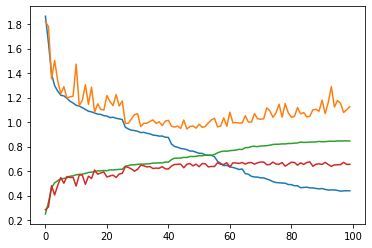

In [11]:
plt.plot(hist), best_acc, curloss

In [13]:
import pickle

pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_1_hist.hdf5', 'wb'))


### SVGG3_2

In [17]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [18]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, **kwargs):
        super(Attention, self).__init__()
        
        self.iconv_out = nn.Conv2d(feature_depth, feature_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(feature_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):

        _x1 = nn.Flatten(-2)(x)
        _x2 = nn.Flatten(-2)(x)
            
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / (_x1.size(1) * _x1.size(2))
        QK = (QK + QK.permute(0,2,1)).sum(1)
        QK = QK.sigmoid()
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x
        
        identity_x = self.iconv_out(x)
        identity_x = self.bn_out(x)

        x_out = x_out + identity_x
        
        x_out = nn.ReLU()(x_out)
        
        return x_out

In [19]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64,).to(self.device)
        self.wf1 = Attention(128).to(self.device)
        self.wf2 = Attention(256).to(self.device)
        self.wf3 = Attention(512).to(self.device)
        self.wf4 = Attention(1024).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [20]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [21]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_2'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.921  | Avg.acc: 0.232
- Avg. val_loss: 1.746  | Avg. val_acc: 0.293
* Update optimal model
Epoch:  2
- Avg.loss: 1.523  | Avg.acc: 0.403
- Avg. val_loss: 1.420  | Avg. val_acc: 0.464
* Update optimal model
Epoch:  3
- Avg.loss: 1.330  | Avg.acc: 0.494
- Avg. val_loss: 1.356  | Avg. val_acc: 0.474
* Update optimal model
Epoch:  4
- Avg.loss: 1.258  | Avg.acc: 0.524
- Avg. val_loss: 1.320  | Avg. val_acc: 0.518
* Update optimal model
Epoch:  5
- Avg.loss: 1.225  | Avg.acc: 0.536
- Avg. val_loss: 1.405  | Avg. val_acc: 0.486
Epoch:  6
- Avg.loss: 1.192  | Avg.acc: 0.549
- Avg. val_loss: 1.292  | Avg. val_acc: 0.496
Epoch:  7
- Avg.loss: 1.172  | Avg.acc: 0.559
- Avg. val_loss: 1.208  | Avg. val_acc: 0.557
* Update optimal model
Epoch:  8
- Avg.loss: 1.152  | Avg.acc: 0.566
- Avg. val_loss: 1.172  | Avg. val_acc: 0.556
Epoch:  9
- Avg.loss: 1.139  | Avg.acc: 0.573
- Avg. val_loss: 1.210  | Avg. val_acc: 0.557
* Update optimal model
Epoch:  10
- Avg.loss: 1.122  | Av

- Avg.loss: 0.574  | Avg.acc: 0.794
- Avg. val_loss: 0.964  | Avg. val_acc: 0.678
Epoch:  83
- Avg.loss: 0.568  | Avg.acc: 0.793
- Avg. val_loss: 1.026  | Avg. val_acc: 0.655
Epoch    83: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  84
- Avg.loss: 0.554  | Avg.acc: 0.801
- Avg. val_loss: 0.965  | Avg. val_acc: 0.681
* Update optimal model
Epoch:  85
- Avg.loss: 0.551  | Avg.acc: 0.798
- Avg. val_loss: 1.072  | Avg. val_acc: 0.659
Epoch:  86
- Avg.loss: 0.549  | Avg.acc: 0.802
- Avg. val_loss: 1.062  | Avg. val_acc: 0.661
Epoch:  87
- Avg.loss: 0.543  | Avg.acc: 0.800
- Avg. val_loss: 1.003  | Avg. val_acc: 0.660
Epoch:  88
- Avg.loss: 0.541  | Avg.acc: 0.805
- Avg. val_loss: 0.971  | Avg. val_acc: 0.680
Epoch:  89
- Avg.loss: 0.538  | Avg.acc: 0.806
- Avg. val_loss: 1.002  | Avg. val_acc: 0.680
Epoch:  90
- Avg.loss: 0.538  | Avg.acc: 0.807
- Avg. val_loss: 0.984  | Avg. val_acc: 0.672
Epoch:  91
- Avg.loss: 0.531  | Avg.acc: 0.808
- Avg. val_loss: 1.046  | Avg. val_acc: 0.

([<matplotlib.lines.Line2D at 0x7f39804e7588>,
 0.6813038793103449,
 0.9648143649101257)

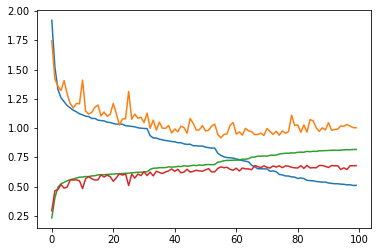

In [22]:
plt.plot(hist), best_acc, curloss

In [24]:
import pickle
pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_2_hist.hdf5', 'wb'))

In [25]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_2.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 0.946  | Avg. val_acc: 0.682


### SVGG3_3

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [6]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, **kwargs):
        super(Attention, self).__init__()
        
        self.conv1a = nn.Sequential(nn.Conv1d(feature_depth, feature_depth, 3, stride=1, padding=1),
                                    nn.BatchNorm1d(feature_depth))
        self.conv1b = nn.Sequential(nn.Conv1d(feature_depth, feature_depth, 3, stride=1, padding=1),
                                    nn.BatchNorm1d(feature_depth))
#         self.conv1c = nn.Sequential(nn.Conv1d(feature_depth, feature_depth, 3, stride=1, padding=1),
#                                     nn.BatchNorm1d(feature_depth))
        
        self.iconv_out = nn.Conv2d(feature_depth, feature_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(feature_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):

        _x1 = nn.Flatten(-2)(x)
        _x2 = nn.Flatten(-2)(x)
            
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / (_x1.size(1) * _x1.size(2))
        
        QK_a = self.conv1a(QK)
        QK_b = self.conv1b(QK.permute(0,2,1))
        
        QK_out = QK_a + QK_b
        QK_out = QK_out.sum(1)
        QK_out = nn.Sigmoid()(QK_out)
        QK_out = QK_out.unsqueeze(-1).unsqueeze(-1)
        
        x_out = (1 + QK_out) * x
        
        identity_x = self.iconv_out(x)
        identity_x = self.bn_out(x)

        x_out = x_out + identity_x
        
        x_out = nn.ReLU()(x_out)
        
        return x_out

In [7]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64,).to(self.device)
        self.wf1 = Attention(128).to(self.device)
        self.wf2 = Attention(256).to(self.device)
        self.wf3 = Attention(512).to(self.device)
        self.wf4 = Attention(1024).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [8]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_3'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.833  | Avg.acc: 0.249
- Avg. val_loss: 1.765  | Avg. val_acc: 0.273
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.742  | Avg.acc: 0.283
- Avg. val_loss: 1.711  | Avg. val_acc: 0.308
* Update optimal model
Epoch:  3
- Avg.loss: 1.598  | Avg.acc: 0.369
- Avg. val_loss: 1.518  | Avg. val_acc: 0.406
* Update optimal model
Epoch:  4
- Avg.loss: 1.457  | Avg.acc: 0.432
- Avg. val_loss: 1.447  | Avg. val_acc: 0.436
* Update optimal model
Epoch:  5
- Avg.loss: 1.375  | Avg.acc: 0.463
- Avg. val_loss: 1.411  | Avg. val_acc: 0.450
* Update optimal model
Epoch:  6
- Avg.loss: 1.339  | Avg.acc: 0.483
- Avg. val_loss: 1.324  | Avg. val_acc: 0.484
* Update optimal model
Epoch:  7
- Avg.loss: 1.316  | Avg.acc: 0.495
- Avg. val_loss: 1.280  | Avg. val_acc: 0.506
* Update optimal model
Epoch:  8
- Avg.loss: 1.297  | Avg.acc: 0.502
- Avg. val_loss: 1.278  | Avg. val_acc: 0.506
Epoch:  9
- Avg.loss: 1.276  | Avg.acc: 0.511
- Avg. val_loss: 1.283  | Avg. val_acc: 0.510
* Update optimal model
Epoch:  10
- Avg.loss: 1.266  | Avg.acc: 0.516
- Avg. val_loss: 1.270  | Avg. val_acc: 0.513
* Update optimal mod

- Avg.loss: 0.951  | Avg.acc: 0.647
- Avg. val_loss: 0.998  | Avg. val_acc: 0.628
Epoch:  86
- Avg.loss: 0.948  | Avg.acc: 0.644
- Avg. val_loss: 1.016  | Avg. val_acc: 0.617
Epoch:  87
- Avg.loss: 0.944  | Avg.acc: 0.646
- Avg. val_loss: 1.013  | Avg. val_acc: 0.623
Epoch:  88
- Avg.loss: 0.938  | Avg.acc: 0.651
- Avg. val_loss: 0.996  | Avg. val_acc: 0.626
Epoch:  89
- Avg.loss: 0.949  | Avg.acc: 0.643
- Avg. val_loss: 0.989  | Avg. val_acc: 0.621
Epoch:  90
- Avg.loss: 0.943  | Avg.acc: 0.647
- Avg. val_loss: 0.995  | Avg. val_acc: 0.623
Epoch:  91
- Avg.loss: 0.943  | Avg.acc: 0.649
- Avg. val_loss: 0.986  | Avg. val_acc: 0.623
Epoch:  92
- Avg.loss: 0.942  | Avg.acc: 0.647
- Avg. val_loss: 1.009  | Avg. val_acc: 0.626
Epoch:  93
- Avg.loss: 0.936  | Avg.acc: 0.649
- Avg. val_loss: 1.006  | Avg. val_acc: 0.621
Epoch:  94
- Avg.loss: 0.939  | Avg.acc: 0.648
- Avg. val_loss: 0.990  | Avg. val_acc: 0.622
Epoch:  95
- Avg.loss: 0.942  | Avg.acc: 0.649
- Avg. val_loss: 1.003  | Avg. val

([<matplotlib.lines.Line2D at 0x7fdeffca6c50>,
 0.6319137168141593,
 0.982528265598601)

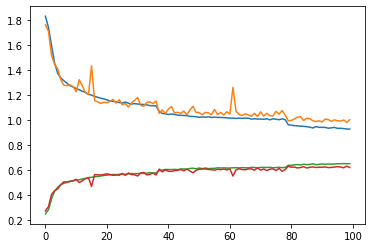

In [10]:
plt.plot(hist), best_acc, curloss

In [11]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_3'
model_path = os.path.join(model_folder, model_name + '.pt')

# best_acc = 0.0
# curloss = 0.0
# hist = []

for epoch in range(100, 150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
- Avg.loss: 0.930  | Avg.acc: 0.654
- Avg. val_loss: 0.995  | Avg. val_acc: 0.625
Epoch:  102
- Avg.loss: 0.929  | Avg.acc: 0.652
- Avg. val_loss: 0.978  | Avg. val_acc: 0.626
Epoch:  103
- Avg.loss: 0.930  | Avg.acc: 0.654
- Avg. val_loss: 0.987  | Avg. val_acc: 0.624
Epoch:  104
- Avg.loss: 0.933  | Avg.acc: 0.655
- Avg. val_loss: 1.012  | Avg. val_acc: 0.619
Epoch:  105
- Avg.loss: 0.921  | Avg.acc: 0.654
- Avg. val_loss: 0.993  | Avg. val_acc: 0.628
Epoch:  106
- Avg.loss: 0.924  | Avg.acc: 0.653
- Avg. val_loss: 0.986  | Avg. val_acc: 0.633
* Update optimal model
Epoch:  107
- Avg.loss: 0.925  | Avg.acc: 0.652
- Avg. val_loss: 1.024  | Avg. val_acc: 0.608
Epoch:  108
- Avg.loss: 0.933  | Avg.acc: 0.653
- Avg. val_loss: 0.975  | Avg. val_acc: 0.627
Epoch:  109
- Avg.loss: 0.926  | Avg.acc: 0.657
- Avg. val_loss: 1.012  | Avg. val_acc: 0.614
Epoch:  110
- Avg.loss: 0.924  | Avg.acc: 0.656
- Avg. val_loss: 1.013  | Avg. val_acc: 0.625
Epoch:  111
- Avg.loss: 0.921  | Avg.

KeyboardInterrupt: 

## SVGG3_4

In [4]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [5]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, **kwargs):
        super(Attention, self).__init__()
        
        self.iconv_out = nn.Conv2d(feature_depth, feature_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(feature_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):

        _x1 = nn.Flatten(-2)(x)
        _x2 = nn.Flatten(-2)(x)
            
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / (_x1.size(1) * _x1.size(2))
        QK = (QK * QK.permute(0,2,1)).sum(1)
        QK = nn.Softmax(dim=1)(QK)
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x
        
        identity_x = self.iconv_out(x)
        identity_x = self.bn_out(x)

        x_out = x_out + identity_x
        
        x_out = nn.ReLU()(x_out)
        
        return x_out

In [6]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64,).to(self.device)
        self.wf1 = Attention(128).to(self.device)
        self.wf2 = Attention(256).to(self.device)
        self.wf3 = Attention(512).to(self.device)
        self.wf4 = Attention(1024).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [ ]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_4'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.874  | Avg.acc: 0.246
- Avg. val_loss: 1.779  | Avg. val_acc: 0.263
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.639  | Avg.acc: 0.343
- Avg. val_loss: 1.515  | Avg. val_acc: 0.420
* Update optimal model
Epoch:  3
- Avg.loss: 1.429  | Avg.acc: 0.445
- Avg. val_loss: 1.377  | Avg. val_acc: 0.474
* Update optimal model
Epoch:  4
- Avg.loss: 1.338  | Avg.acc: 0.485
- Avg. val_loss: 1.360  | Avg. val_acc: 0.485
* Update optimal model
Epoch:  5
- Avg.loss: 1.302  | Avg.acc: 0.502
- Avg. val_loss: 1.366  | Avg. val_acc: 0.481
Epoch:  6
- Avg.loss: 1.269  | Avg.acc: 0.515
- Avg. val_loss: 1.281  | Avg. val_acc: 0.511
* Update optimal model
Epoch:  7
- Avg.loss: 1.250  | Avg.acc: 0.522
- Avg. val_loss: 1.307  | Avg. val_acc: 0.499
Epoch:  8
- Avg.loss: 1.223  | Avg.acc: 0.533
- Avg. val_loss: 1.256  | Avg. val_acc: 0.521
* Update optimal model
Epoch:  9
- Avg.loss: 1.208  | Avg.acc: 0.540
- Avg. val_loss: 1.165  | Avg. val_acc: 0.558
* Update optimal model
Epoch:  10
- Avg.loss: 1.183  | Avg.acc: 0.552
- Avg. val_loss: 1.182  | Avg. val_acc: 0.551
Epoch:  11
- Avg.loss: 1.167  | Avg.acc: 0.

([<matplotlib.lines.Line2D at 0x7fe1b585a6d8>,
 0.6620065789473685,
 0.9626915465321457)

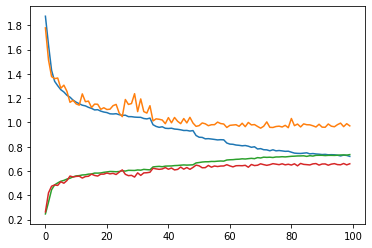

In [10]:
plt.plot(hist), best_acc, curloss

In [24]:
import pickle
pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_4_hist.hdf5', 'wb'))

## SVGG3_5

In [4]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [5]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.conv1a = nn.Sequential(nn.Conv1d(feature_depth, emb_dim, 3, stride=1, padding=1),
                                    nn.BatchNorm1d(emb_dim))
        self.conv1b = nn.Sequential(nn.Conv1d(feature_depth, emb_dim, 3, stride=1, padding=1),
                                    nn.BatchNorm1d(emb_dim))
#         self.conv1c = nn.Sequential(nn.Conv1d(feature_depth, feature_depth, 3, stride=1, padding=1),
#                                     nn.BatchNorm1d(feature_depth))
        
        self.iconv_out = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(emb_dim)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):

        _x1 = nn.Flatten(-2)(x)
        _x2 = nn.Flatten(-2)(x)
            
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / (_x1.size(1) * _x1.size(2))
        
        QK_a = self.conv1a(QK)
        QK_b = self.conv1b(QK.permute(0,2,1))
        
        QK_out = QK_a * QK_b
        QK_out = QK_out.sum(1)
        QK_out = nn.Sigmoid()(QK_out)
        QK_out = QK_out.unsqueeze(-1).unsqueeze(-1)
        
        x = self.iconv_out(x)
        x = self.bn_out(x)

        
        x_out = (1 + QK_out) * x
        
        return x_out, (QK_a, QK_b)

In [6]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 512).to(self.device)

        self.wf0 = Attention(64, 64).to(self.device)
        self.wf1 = Attention(128, 128).to(self.device)
        self.wf2 = Attention(256, 256).to(self.device)
        self.wf3 = Attention(512, 512).to(self.device)
        self.wf4 = Attention(512, 512).to(self.device)

        self.fc1 = nn.Linear(512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0, x0_f = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1, x1_f = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2, x2_f = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3, x3_f = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4, x4_f = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x, (x0_f, x1_f, x2_f, x3_f, x4_f)

In [7]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
sub_criterion = nn.MSELoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [ ]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_5'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sub_f = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        
        loss = criterion(outputs, labels)
        
        sub_loss = torch.Tensor([sub_criterion(k[0], k[1]) for k in sub_f]).mean()
        
        loss = loss - 0.5*sub_loss
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sub_f = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        sub_loss = torch.Tensor([sub_criterion(k[0], k[1]) for k in sub_f]).mean()
        
        loss = loss + 0.5*sub_loss
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 0.972  | Avg.acc: 0.234
- Avg. val_loss: 2.447  | Avg. val_acc: 0.272


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
- Avg.loss: 1.166  | Avg.acc: 0.298
- Avg. val_loss: 2.350  | Avg. val_acc: 0.308
* Update optimal model
Epoch:  3
- Avg.loss: 1.171  | Avg.acc: 0.415
- Avg. val_loss: 1.698  | Avg. val_acc: 0.435
* Update optimal model
Epoch:  4
- Avg.loss: 1.185  | Avg.acc: 0.465
- Avg. val_loss: 1.484  | Avg. val_acc: 0.485
* Update optimal model
Epoch:  5
- Avg.loss: 1.217  | Avg.acc: 0.478
- Avg. val_loss: 1.794  | Avg. val_acc: 0.401
Epoch:  6
- Avg.loss: 1.222  | Avg.acc: 0.488
- Avg. val_loss: 1.862  | Avg. val_acc: 0.353
Epoch:  7
- Avg.loss: 1.240  | Avg.acc: 0.499
- Avg. val_loss: 1.385  | Avg. val_acc: 0.474
Epoch:  8
- Avg.loss: 1.239  | Avg.acc: 0.505
- Avg. val_loss: 1.345  | Avg. val_acc: 0.498
* Update optimal model
Epoch:  9
- Avg.loss: 1.240  | Avg.acc: 0.508
- Avg. val_loss: 1.415  | Avg. val_acc: 0.470
Epoch:  10
- Avg.loss: 1.238  | Avg.acc: 0.520
- Avg. val_loss: 1.279  | Avg. val_acc: 0.526
* Update optimal model
Epoch:  11
- Avg.loss: 1.228  | A

([<matplotlib.lines.Line2D at 0x7f4fcc8c0208>,
 0.6524122807017544,
 0.9736590882142385)

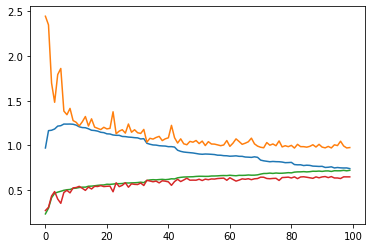

In [10]:
plt.plot(hist), best_acc, curloss

In [11]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_5'
model_path = os.path.join(model_folder, model_name + '.pt')

# best_acc = 0.0
# curloss = 0.0
# hist = []

for epoch in range(100, 120):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sub_f = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        
        loss = criterion(outputs, labels)
        
        sub_loss = torch.Tensor([sub_criterion(k[0], k[1]) for k in sub_f]).mean()
        
        loss = loss - 0.5*sub_loss
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sub_f = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        sub_loss = torch.Tensor([sub_criterion(k[0], k[1]) for k in sub_f]).mean()
        
        loss = loss + 0.5*sub_loss
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
- Avg.loss: 0.739  | Avg.acc: 0.720
- Avg. val_loss: 0.979  | Avg. val_acc: 0.649
Epoch:  102
- Avg.loss: 0.737  | Avg.acc: 0.722
- Avg. val_loss: 0.979  | Avg. val_acc: 0.647
Epoch:  103
- Avg.loss: 0.739  | Avg.acc: 0.723
- Avg. val_loss: 0.995  | Avg. val_acc: 0.642
Epoch:  104
- Avg.loss: 0.740  | Avg.acc: 0.720
- Avg. val_loss: 0.994  | Avg. val_acc: 0.641
Epoch:  105
- Avg.loss: 0.733  | Avg.acc: 0.724
- Avg. val_loss: 1.014  | Avg. val_acc: 0.644
Epoch:  106
- Avg.loss: 0.731  | Avg.acc: 0.725
- Avg. val_loss: 0.982  | Avg. val_acc: 0.650
Epoch:  107
- Avg.loss: 0.734  | Avg.acc: 0.722
- Avg. val_loss: 1.001  | Avg. val_acc: 0.647
Epoch:  108
- Avg.loss: 0.727  | Avg.acc: 0.725
- Avg. val_loss: 1.007  | Avg. val_acc: 0.630
Epoch:  109
- Avg.loss: 0.735  | Avg.acc: 0.723
- Avg. val_loss: 0.979  | Avg. val_acc: 0.648
Epoch   109: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  110
- Avg.loss: 0.728  | Avg.acc: 0.725
- Avg. val_loss: 1.013  | Avg. val_acc: 0.64

([<matplotlib.lines.Line2D at 0x7f4fcc2f20f0>,
 0.6526864035087719,
 0.9791002017364168)

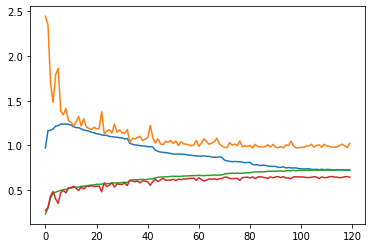

In [12]:
plt.plot(hist), best_acc, curloss

In [13]:
import pickle

pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_5_hist.hdf5', 'wb'))

In [15]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_5.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sub_f = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    sub_loss = torch.Tensor([sub_criterion(k[0], k[1]) for k in sub_f]).mean()

    loss = loss - 0.5*sub_loss

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))


- Avg. val_loss: 0.924  | Avg. val_acc: 0.665
